# MNIST Dataset: Density Forests
Trains a simple CNN on _N-1_ classes of the MNIST dataset, predicts unseen classes using baseline methods and Density Forest.

In [58]:
#import libraries
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn import decomposition, svm, metrics
from tensorflow.python.client import device_lib

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "9"

#custom libraries
base_dir = '/Users/cyrilwendl/Documents/EPFL'
#base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich')  # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package
from density_forest.density_forest import *
from density_forest.plots import *
from density_forest.helpers import *
from baselines.helpers import *
from helpers.helpers import *
from helpers.plots import *
from helpers.cv_scorers import *
from helpers.cross_validator import ParameterSearch
from parametric_tSNE.utils import *

# print available devices
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17676993077916136188
]


# Data Import 
Import the data, delete all data in the training set of class 7


In [76]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train_all, y_train_all), (x_test_all, y_test_all) = mnist.load_data()
print(np.unique(y_train_all, return_counts=True))

label_to_remove = 8

# remove all trainig samples containing a label label_to_remove
x_train = x_train_all[y_train_all != label_to_remove]
y_train = y_train_all[y_train_all != label_to_remove]
    
x_test = x_test_all[y_test_all != label_to_remove]
y_test = y_test_all[y_test_all != label_to_remove]

# decrease all labels that are higher by -1 to avoid gaps
for i in range(label_to_remove + 1, 11):
    y_train[y_train == i] = (i-1)
    y_test[y_test == i] = (i-1)
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5949]))


In [77]:
batch_size = 128
num_classes = 9
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_all = x_test_all.astype('float32')
x_train /= 255
x_test /= 255
x_test_all /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (54149, 28, 28, 1)
54149 train samples
9026 test samples


In [78]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False
if model_train:
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
              verbose=1, validation_data=(x_test, y_test))
    model.save('mnist_models/mnist-weights-' + str(label_to_remove) + '.h5')
else:
    model = load_model('mnist_models/mnist-weights-' + str(label_to_remove) + '.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
__________

#### Make some predictions for the unseen class

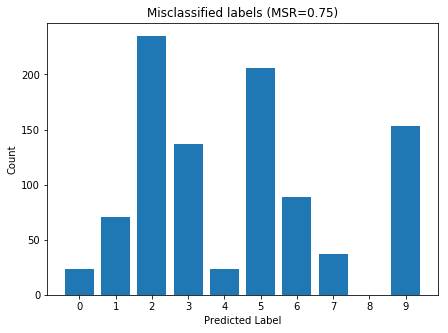

In [79]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all == label_to_remove)[0]] 

# make prodictions for class unseen during training
y_pred = model.predict(x_unseen_class)
y_pred_label = get_y_pred_labels(y_pred, label_to_remove, background=False)

# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label, return_counts=True)

# visualization
plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Misclassified labels (MSR=%.2f)" % np.mean(get_acc_net_msr(y_pred)))
plt.savefig("../Figures/MNIST/pred-count_wo_cl" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [80]:
# Avarage certitude for unseen class: 1-max_margin
c = get_acc_net_max_margin(y_pred)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean * 100))
print("Std accuracy: %.2f %%" % (pred_acc_std * 100))

pred_acc_high = .95

pct = np.round(len(c[c > pred_acc_high]) / len(c), 4) * 100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 58.34 %
Std accuracy: 32.16 %
17.56% of all predictions made with an accuracy higher than 0.95%


In [81]:
# Avarage certitude for seen class: 1-max_margin
y_pred_seen = model.predict(x_test)
y_pred_label_seen = get_y_pred_labels(y_pred_seen, label_to_remove, background=False)

c = get_acc_net_max_margin(y_pred_seen)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean * 100))
print("Std accuracy: %.2f %%" % (pred_acc_std * 100))

pred_acc_high = .95

pct = np.round(len(c[c > pred_acc_high])/len(c), 4) * 100
print("%.2f %% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 98.68 %
Std accuracy: 8.16 %
96.37 % of all predictions made with an accuracy higher than 0.95%


In [82]:
# get all predictions in training and test set
y_pred_tr = model.predict(x_train_all[..., np.newaxis])
y_pred_label_tr = get_y_pred_labels(y_pred_tr, class_to_remove=label_to_remove, background=False)

y_pred_te = model.predict(x_test_all)
y_pred_label_te = get_y_pred_labels(y_pred_te, class_to_remove=label_to_remove, background=False)

In [83]:
# get indices of correctly / incorrectly predicted images
pred_t_tr = y_train_all != label_to_remove
pred_f_tr = y_train_all == label_to_remove

pred_t_te = y_test_all != label_to_remove
pred_f_te = y_test_all == label_to_remove

In [84]:
# TODO metrics

## Network accuracy

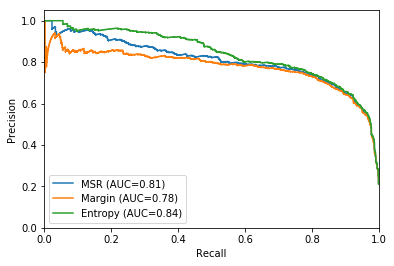

In [85]:
# precision-recall curves

# msr
y_scores = 1-get_acc_net_msr(y_pred_te)
y_true = pred_f_te
precision_msr, recall_msr, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
auroc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = 1-get_acc_net_max_margin(y_pred_te)
precision_margin, recall_margin, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
auroc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = 1-get_acc_net_entropy(y_pred_te)
precision_entropy, recall_entropy, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
auroc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

# plot
plt.step(recall_msr, precision_msr, where='post')
plt.step(recall_margin, precision_margin, where='post')
plt.step(recall_entropy, precision_entropy, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('MSR (AUC=%.2f)' % pr_auc_msr),
            str.format('Margin (AUC=%.2f)' % pr_auc_margin),
            str.format('Entropy (AUC=%.2f)' % pr_auc_entropy)])

# Dropout

In [86]:
y_preds = predict_with_dropouts_batch(model, x_test_all, 
                                      batch_size=100, n_iter=5)

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


In [87]:
y_pred = np.mean(y_preds, axis=0)
probas = -get_acc_net_entropy(y_pred)

In [88]:
# Metrics
# PR
precision_dropout, recall_dropout, _ = metrics.precision_recall_curve(y_true, probas)
pr_auc_dropout = metrics.auc(recall_dropout, precision_dropout)
# ROC
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, probas)
auroc_dropout = metrics.roc_auc_score(y_true, probas)

# Activation weights visualization

(1, 1, 24, 24, 64)


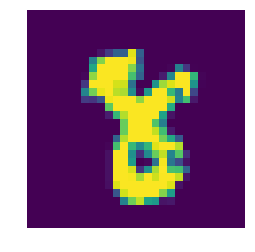

In [89]:
ind_im_test = 10
activations = get_activations(model, 1, x_unseen_class[ind_im_test][np.newaxis])
print(np.shape(activations))
plt.imshow(x_unseen_class[ind_im_test][:, :, 0])
plt.axis('off')
plt.show()

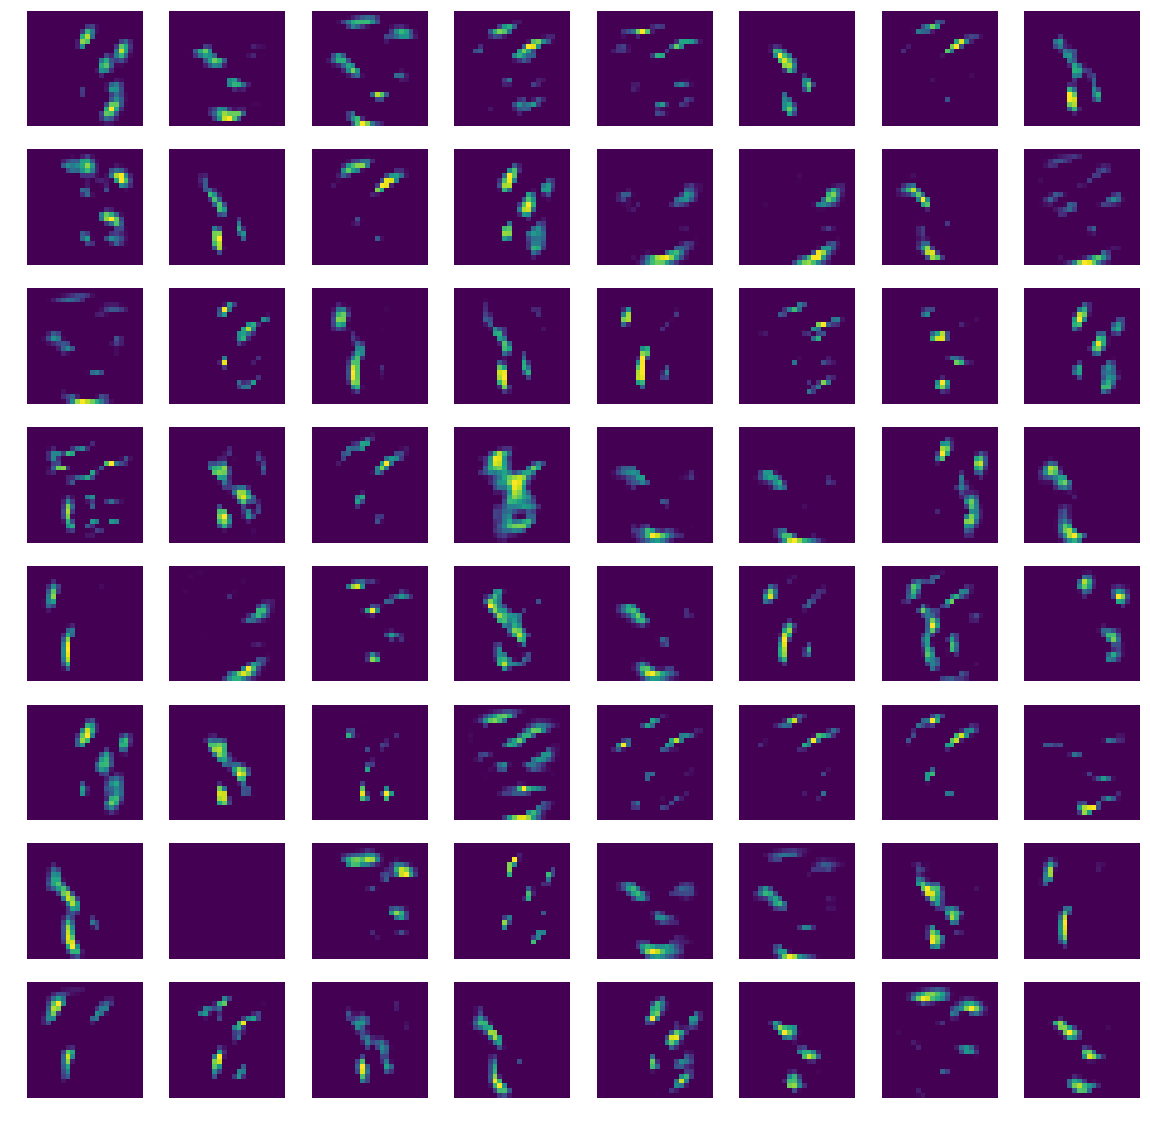

In [90]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(20, 20)
for i in range(8):
    for j in range(8):
        axes[i][j].imshow(activations[0][0][:, :, i * 8 + j])
        axes[i][j].set_axis_off()
plt.show()

# Density Forest
## Get Activations, PCA, t-SNE

In [91]:
# get activation weights of last layer
act_unseen = get_activations(model, 6, x_unseen_class)[0]
print(np.shape(act_unseen))

act_train_all = get_activations_batch(model, 6, x_train_all[..., np.newaxis], 20, verbose=True)
print(np.shape(act_train_all))

act_train = act_train_all[y_train_all != label_to_remove]
print(np.shape(act_train))


act_test = get_activations(model, 6, x_test_all)[0]
print(np.shape(act_test))

  0%|          | 0/3000 [00:00<?, ?it/s]

(974, 128)


100%|██████████| 3000/3000 [00:28<00:00, 106.00it/s]


(60000, 128)
(54149, 128)
(10000, 128)


In [92]:
pts_per_class = 300
n_classes = 10
dataset_subset_indices = get_balanced_subset_indices(y_test_all, np.arange(n_classes), pts_per_class)

In [93]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
# t-SNE visualization after PCA
# tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

In [94]:
# color scale and legend for t-sne plots
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))[:, :3]
names = ['Class ' + str(i) for i in range(10)]
classes_to_keep = np.asarray([x for x in range(n_classes) if x != label_to_remove])

# plot
tsne_y = y_test_all[np.concatenate(dataset_subset_indices)]

Variance explained by first 15 components: 0.88


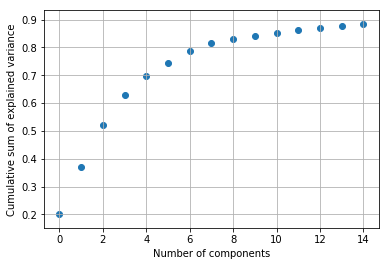

In [95]:
# PCA
n_components = 15
pca = decomposition.PCA(n_components=n_components)
pca.fit(act_train)

# plot
print("Variance explained by first %i components: %.2f" % (n_components, 
                                                           np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../Figures/MNIST/pca_components_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [96]:
# fit PCA
X_train = pca.transform(act_train)
X_train_all = pca.transform(act_train_all)
X_test = pca.transform(act_test)

#### Visualize PCA

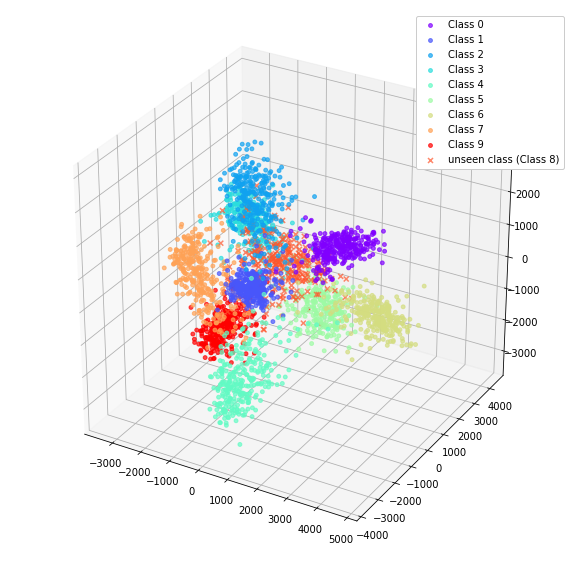

In [97]:
# test sample (with unseen class)
plot_pts_3d(X_train_all, y_train_all, classes_to_keep, names, colors, class_to_remove=label_to_remove, 
            subsample_pct=.05, s_name="../Figures/MNIST/MINST_PCA_3D_wo_cl_" + str(label_to_remove) + ".pdf")

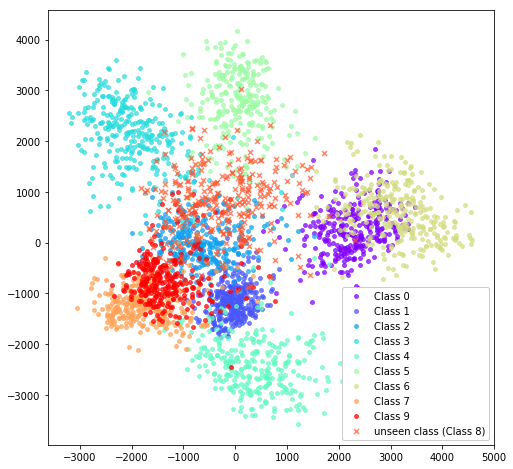

In [98]:
# test sample (with unseen class)
plt, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_pts_2d(X_train_all, y_train_all, ax, classes_to_keep, names, colors, class_to_remove=label_to_remove, 
            subsample_pct=.05)
plt.savefig("../Figures/MNIST/MINST_PCA_2D_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

In [99]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.015s...
[t-SNE] Computed neighbors for 10000 samples in 0.741s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.551341
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.972076
[t-SNE] Error after 300 iterations: 2.718528


In [100]:
import matplotlib.pyplot as plt

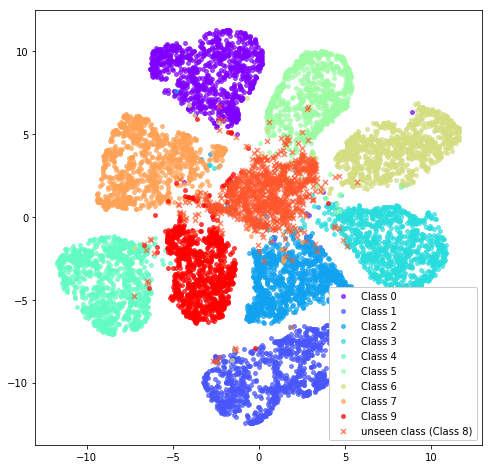

In [101]:
# plot
_, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_pts_2d(tsne_all, y_test_all, ax, classes_to_keep, names,
            colors, class_to_remove=label_to_remove)

plt.savefig("../Figures/MNIST/MINST_t-SNE_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

In [102]:
tsne_train = tsne_all[y_test_all != label_to_remove]

### GMM
GMM, calculate 

In [103]:
tuned_parameters = [{'n_components': np.arange(4, 12), 
                     'max_iter': [10000]}]

# do parameter search
ps_gmm = ParameterSearch(GaussianMixture, tuned_parameters, X_train, X_train_all, 
                         pred_f_tr[y_train_all < np.infty], scorer_roc_probas_gmm, 
                         n_iter=3, verbosity=11, n_jobs=1, subsample_train=.05, subsample_test=.05)
ps_gmm.fit()

Trying parameters: {'max_iter': 10000, 'n_components': 4}
Trying parameters: {'max_iter': 10000, 'n_components': 5}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


Trying parameters: {'max_iter': 10000, 'n_components': 6}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


Trying parameters: {'max_iter': 10000, 'n_components': 7}
Trying parameters: {'max_iter': 10000, 'n_components': 8}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s


Trying parameters: {'max_iter': 10000, 'n_components': 9}


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


Trying parameters: {'max_iter': 10000, 'n_components': 10}


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.7s remaining:    0.0s


Trying parameters: {'max_iter': 10000, 'n_components': 11}


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.2s finished


In [104]:
print(ps_gmm.best_params)

{'max_iter': 10000, 'n_components': 8}


In [105]:
# fit model
gmm = GaussianMixture(**ps_gmm.best_params)
gmm.fit(X_test)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=10000,
        means_init=None, n_components=8, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [106]:
# predict
probas = gmm.predict_proba(X_test)
probas = get_acc_net_entropy(probas)

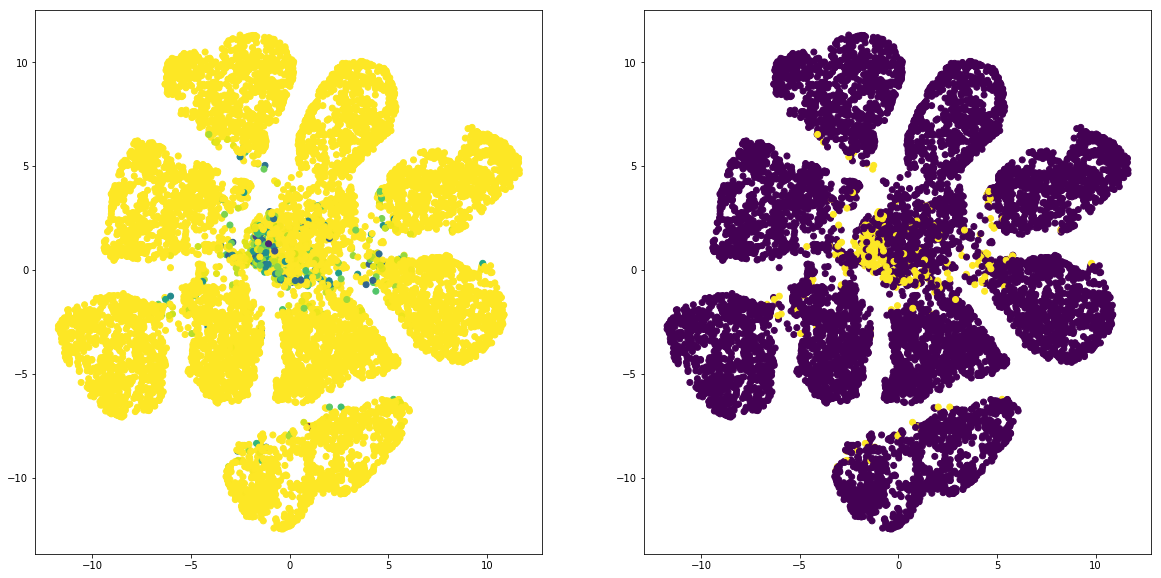

In [107]:
_, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0], tsne_all[:, 1], c=probas)  # certainty for each point
axes[1].scatter(tsne_all[:, 0], tsne_all[:, 1], c=probas < np.sort(probas)[300])  # 300 least certain points in yellow

In [108]:
# Metrics
# PR
precision_gmm, recall_gmm, _ = metrics.precision_recall_curve(y_true, -probas)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)
# ROC
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, -probas)
auroc_gmm = metrics.roc_auc_score(y_true, -probas)

print("PR AUC: %.2f, AUROC: %.2f" % (pr_auc_gmm, auroc_gmm))

PR AUC: 0.39, AUROC: 0.82


## One-Class SVM

In [109]:
X_train_svm = preprocessing.scale(X_train)
X_train_all_svm = preprocessing.scale(X_train_all)
X_test_svm = preprocessing.scale(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [164]:
import itertools as it
import multiprocessing
import numpy as np
from joblib import Parallel, delayed
from density_forest.helpers import draw_subsamples
import pandas as pd


class ParameterSearch:
    """
    class for performing cross validation, using a training set, test set and a custom scoring function
    to evaluate a model.
    """

    def __init__(self, model, params_test, x_train, x_test, y_true, f_scoring, n_iter, verbosity=0, n_jobs=-1,
                 default_params=None, subsample_train=1, subsample_test=1):
        """
        Initiate
        :param model: Model to use, e.g., GaussianMixtureModel. Must have a fit method
        :param params_test: Parameters to test in grid search, list of dicts
        :param params_test: Default arguments, dict
        :param x_train: training points for fit method
        :param x_test: testing points for scorer
        :param y_true: gt for scorer
        :param f_scoring: scoring function, taking (model, x_test, y_true) as input, returning a scalar
        :param n_iter: number of iterations for each parameter setting (averaging)
        :param verbosity: verbosity level of outputs
        :param n_jobs: number of processor cores to use. If n_jobs=-1, all cores are used
        :param subsample_train: percentage of data to use for training (default: all)
        :param subsample_test: percentage of data to use for testing (default: all)
        """
        # TODO separate default values and CV values
        self.model = model
        self.params_test = params_test
        self.x_train = x_train
        self.x_test = x_test
        self.f_scoring = f_scoring
        self.y_true = y_true
        self.verbosity = verbosity
        self.subsample_train = subsample_train
        self.subsample_test = subsample_test
        self.n_iter = n_iter

        if n_jobs == -1:
            self.n_jobs = multiprocessing.cpu_count()
        else:
            self.n_jobs = np.min([n_jobs, multiprocessing.cpu_count()])

        # all possible parameter combinations for all lists of parameters to test (without defaults)
        self.combinations = []
        for p_test_l in params_test:
            params_names = sorted(p_test_l)
            combinations_l = it.product(*(p_test_l[Name] for Name in params_names))
            self.combinations.append([{n: k for k, n in zip(c, params_names)} for c in combinations_l])
        
        self.combinations = np.concatenate(self.combinations)
        if default_params is not None:
            params_test_default = []  # list of dicts with defaults arguments
            for d in params_test:
                d_default = d.copy()  # dict with default args
                for d_k, d_v in zip(default_params.keys(), default_params.values()):
                    d_default[d_k] = [d_v]
                params_test_default.append(d_default)

            self.combinations_default = []
            for p_test_l in params_test_default:
                params_names = sorted(p_test_l)
                combinations_l = it.product(*(p_test_l[Name] for Name in params_names))
                self.combinations_default.append([{n: k for k, n in zip(c, params_names)} for c in combinations_l])
            self.combinations_default = np.concatenate(self.combinations_default)

        else:
            self.combinations_default = self.combinations

        self.best_params = None
        self.results = {}  # results of parameter combinations for which there are results
        # dataframe with all parameters and results
        colnames = list(np.unique(np.concatenate([list(tp.keys()) for tp in params_test])))
        colnames.append('result')  # mean result for a parameter setting
        colnames.append('std')  # variance for a parameter setting
        self.results_df = pd.DataFrame(columns=colnames)
        for idx, c in enumerate(self.combinations):
            self.results_df = self.results_df.append(pd.Series(c).rename(str(idx+1)))
            
        self.results_r_mean = np.array([])  # mean numbers of parameter combinations for which there are results
        self.results_r = np.array([])  # arrays of results for each combination set
        self.results_c = np.array([])  # names of parameter combinations for which there are results

    def fit(self):
        """
        Fit model trying all possible model combinations in parallel self.n_iter times
        :return self
        """
        if self.n_jobs != 0:
            scores_c = Parallel(n_jobs=self.n_jobs, verbose=self.verbosity)(
                delayed(self.fit_iter)(c) for c in self.combinations_default)
        else:
            scores_c = [self.fit_iter(c) for c in self.combinations_default]

        for param_c, scores_c in zip(self.combinations, scores_c):
            self.results_r_mean = np.append(self.results_r_mean, np.mean(scores_c))
            self.results_c = np.append(self.results_c, param_c)
            self.results[str(param_c)] = {'mean score': np.mean(scores_c), 'scores': scores_c}
            self.results_df.loc[self.results_df[list(param_c.keys())].isin(param_c.values()).all(axis=1), 'result'] = \
                np.mean(scores_c)
            self.results_df.loc[self.results_df[list(param_c.keys())].isin(param_c.values()).all(axis=1), 'std'] = \
                np.std(scores_c)

        # best parameters = those with highest score
        self.best_params = self.results_c[np.argmax(self.results_r_mean)]
        return self

    def fit_iter(self, c):
        """
        Fit a model to a parameter combination c for a given time
        :param c: parameter combination to test self.n_iter times
        :return: scores of all self.n_iter runs
        """
        scores_c = []
        if self.verbosity > 0:
            print("Trying parameters: " + str(c))

        for _ in range(self.n_iter):
            # get optionally, get data subsamples
            if self.subsample_train < 1:
                x_train_ss = draw_subsamples(self.x_train, self.subsample_train)
            else:
                x_train_ss = self.x_train

            if self.subsample_test < 1:
                x_test_ss, ind_ss = draw_subsamples(self.x_test, self.subsample_test, return_indices=True)
                y_true_ss = self.y_true[ind_ss]
            else:
                x_test_ss = self.x_test
                y_true_ss = self.y_true

            # fit model
            model_try = self.model(**c)
            model_try.fit(x_train_ss)

            # add score to array
            score = self.f_scoring(model_try, x_test_ss, y_true_ss)
            scores_c.append(score)

        return scores_c


In [167]:
y_true_tr = (y_train_all != y_pred_label_tr) * 1

tuned_parameters = [{'kernel': ['rbf'],
                     'nu': [.001, .5, .99]
                     },
                    {'kernel': ['poly'],
                     'degree': np.arange(1, 17),
                     'nu': [1e-4, 1e-3, 1e-2, .1, .3, .5],
                     'max_iter': [10000]
                     }]

# do parameter search
ps_svm = ParameterSearch(svm.OneClassSVM, tuned_parameters, X_train_svm, X_train_all_svm, 
                         pred_f_tr[y_train_all < np.infty], scorer_roc_probas_svm, n_iter=5, 
                         verbosity=10, n_jobs=-1, subsample_train=.1, subsample_test=.1)

ps_svm.fit()

Trying parameters: {'kernel': 'rbf', 'nu': 0.001}
Trying parameters: {'kernel': 'rbf', 'nu': 0.5}
Trying parameters: {'kernel': 'rbf', 'nu': 0.99}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s


Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.7s


Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.4s


Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 4, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 5, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.1s


Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 6, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.1s


Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 7, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 8, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   16.7s


Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 9, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 10, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   21.3s


Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 11, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 12, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Tryi

[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   26.9s


Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 13, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 14, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Tryi

[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   32.8s


Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.3}
Trying parameters: {'degree': 16, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=8)]: Done  94 out of  99 | elapsed:   38.6s remaining:    2.1s
[Parallel(n_jobs=8)]: Done  99 out of  99 | elapsed:   43.0s finished


In [168]:
print(ps_svm.best_params)

{'degree': 15, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


In [169]:
display(ps_svm.results_df)

,degree,kernel,max_iter,nu,result,std
1,NaN,rbf,NaN,0.0010,0.241172,0.019231
2,NaN,rbf,NaN,0.5000,0.226889,0.011985
3,NaN,rbf,NaN,0.9900,0.228457,0.009585
4,1.0,poly,10000.0,0.0001,0.517387,0.124362
5,1.0,poly,10000.0,0.0010,0.547268,0.124210
6,1.0,poly,10000.0,0.0100,0.673532,0.143266
7,1.0,poly,10000.0,0.1000,0.616326,0.143205
8,1.0,poly,10000.0,0.3000,0.604356,0.119746
9,1.0,poly,10000.0,0.5000,0.538479,0.085075
10,2.0,poly,10000.0,0.0001,0.822364,0.023427


In [170]:
clf_svm = svm.OneClassSVM(**ps_svm.best_params, verbose=True)

In [171]:
clf_svm.fit(X_train_svm)

[LibSVM]

OneClassSVM(cache_size=200, coef0=0.0, degree=15, gamma='auto', kernel='poly',
      max_iter=10000, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=True)

In [172]:
probas = clf_svm.decision_function(X_test_svm)[:, 0]
probas -= np.min(probas)
probas /= np.max(probas)

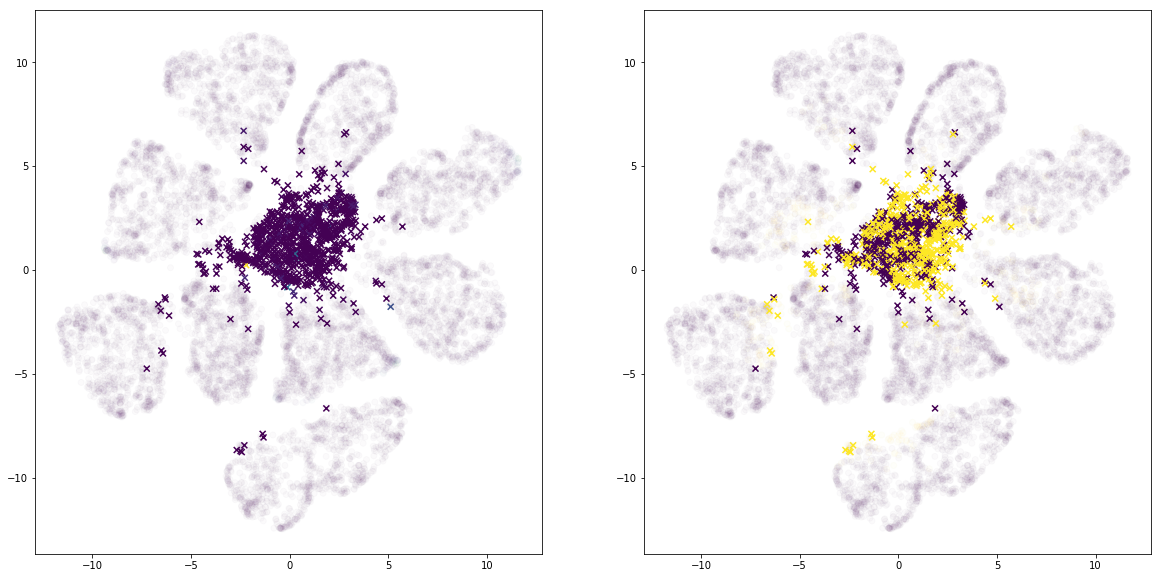

In [173]:
# plot correctly / incorrectly predicted points (x/o marker)
_, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0][pred_t_te], tsne_all[:, 1][pred_t_te], c=probas[pred_t_te], alpha=.02)
axes[1].scatter(tsne_all[:, 0][pred_t_te], tsne_all[:, 1][pred_t_te], 
                c=(probas < np.sort(probas)[1000])[pred_t_te], alpha=.02)

# plot correctly / incorrectly predicted points (x/o marker)
axes[0].scatter(tsne_all[:, 0][pred_f_te], tsne_all[:, 1][pred_f_te], c=probas[pred_f_te], marker='x')
axes[1].scatter(tsne_all[:, 0][pred_f_te], tsne_all[:, 1][pred_f_te], 
                c=(probas < np.sort(probas)[1000])[pred_f_te], marker='x')

In [174]:
# Metrics
# PR
precision_svm, recall_svm, _ = metrics.precision_recall_curve(y_true, -probas)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)
# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, -probas)
auroc_svm = metrics.roc_auc_score(y_true, -probas)

print("PR AUC: %.2f, AUROC: %.2f" % (pr_auc_svm, auroc_svm))

PR AUC: 0.57, AUROC: 0.90


# Density Forest

In [269]:
default_params = {'min_subset': .05,
                  'n_trees': 10,
                  'n_max_dim': 0,
                  'n_jobs': 1,
                  'subsample_pct': .02,
                  'verbose': 1}


tuned_params = [{'max_depth': [2, 3, 4, 5],
                 'ig_improvement': [0, .3, .5, .7, .9]}]

In [270]:
ps_df = ParameterSearch(DensityForest, tuned_params, X_train[..., :2], X_train_all[..., :2],
                        pred_f_tr[y_train_all < np.infty], scorer_roc_probas_df, n_iter=3,
                        verbosity=1, n_jobs=-1, subsample_train=1, subsample_test=1, default_params=default_params)

In [ ]:
ps_df.fit()

Trying parameters: {'ig_improvement': 0, 'max_depth': 2, 'min_subset': 0.05, 'n_jobs': 1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.02, 'verbose': 1}
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Trying parameters: {'ig_improvement': 0, 'max_depth': 3, 'min_subset': 0.05, 'n_jobs': 1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.02, 'verbose': 1}
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Trying parameters: {'ig_improvement': 0, 'max_depth': 4, 'min_subset': 0.05, 'n_jobs': 1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.02, 'verbose': 1}
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Trying parameters: {'ig_improvement': 0, 'max_depth': 5, 'min_subset': 0.05, 'n_jobs': 1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.02, 'verbose': 1}
Number of points on which to train each tree: 1082
Trying parameters: {'ig_improvement': 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.5s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.5s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.3s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.4s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.7s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.6s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.8s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.9s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 12
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 7
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.2s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.3s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.7s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.7s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 12
Number of points on which to train each tree: 1082
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Minimum number of points in each leaf: 54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.7s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.7s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 6
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.1s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 9


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.1s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 9
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Trying parameters: {'ig_improvement': 0.5, 'max_depth': 2, 'min_subset': 0.05, 'n_jobs': 1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.02, 'verbose': 1}
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Trying parameters: {'ig_improvement': 0.5, 'max_depth': 3, 'min_subset': 0.05, 'n_jobs': 1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.02, 'verbose': 1}
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.1s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.5s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 11


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.5s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.6s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.6s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.8s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 12
Trying parameters: {'ig_improvement': 0.5, 'max_depth': 4, 'min_subset': 0.05, 'n_jobs': 1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.02, 'verbose': 1}
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Trying parameters: {'ig_improvement': 0.5, 'max_depth': 5, 'min_subset': 0.05, 'n_jobs': 1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.02, 'verbose': 1}
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.8s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 12
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Trying parameters: {'ig_improvement': 0.7, 'max_depth': 2, 'min_subset': 0.05, 'n_jobs': 1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.02, 'verbose': 1}
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Trying parameters: {'ig_improvement': 0.7, 'max_depth': 3, 'min_subset': 0.05, 'n_jobs': 1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.02, 'verbose': 1}
Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.7s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 12


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished


Number of created root nodes: 9
Mean number of clusters created per tree: 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.5s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 6


In [178]:
print(ps_df.best_params)

{'ig_improvement': 0.7, 'max_depth': 5}


In [179]:
print(ps_df.results)

{"{'ig_improvement': 0, 'max_depth': 2}": {'mean score': 0.8459155983485213, 'scores': [0.8288601996076713, 0.8448748739682024, 0.8640117214696901]}, "{'ig_improvement': 0, 'max_depth': 3}": {'mean score': 0.8736344942245902, 'scores': [0.87539621733898, 0.8699196241907055, 0.875587641144085]}, "{'ig_improvement': 0, 'max_depth': 4}": {'mean score': 0.8702462926638117, 'scores': [0.8713970764735607, 0.8722305976098872, 0.8671112039079873]}, "{'ig_improvement': 0, 'max_depth': 5}": {'mean score': 0.8677725115855649, 'scores': [0.865687610875401, 0.8666061314028282, 0.8710237924784653]}, "{'ig_improvement': 0.3, 'max_depth': 2}": {'mean score': 0.8527574327998458, 'scores': [0.8509817977291678, 0.8518902212253239, 0.8554002794450462]}, "{'ig_improvement': 0.3, 'max_depth': 3}": {'mean score': 0.8694696797718798, 'scores': [0.8644445429142593, 0.874272656691067, 0.8696918397103134]}, "{'ig_improvement': 0.3, 'max_depth': 4}": {'mean score': 0.8636169261792556, 'scores': [0.857151743504322

In [190]:
ps_df.results_df

,ig_improvement,max_depth,result,std
1,0.0,2.0,0.845916,0.014369
2,0.0,3.0,0.873634,0.002628
3,0.0,4.0,0.870246,0.002243
4,0.0,5.0,0.867773,0.002329
5,0.3,2.0,0.852757,0.001905
6,0.3,3.0,0.869470,0.004015
7,0.3,4.0,0.863617,0.006174
8,0.3,5.0,0.866667,0.008959
9,0.5,2.0,0.843842,0.007515
10,0.5,3.0,0.868673,0.007428


In [189]:
ps_df.results_df.groupby('max_depth').mean()

,ig_improvement,result,std
max_depth,,,
2.0,0.375,0.846286,0.007137
3.0,0.375,0.871215,0.005109
4.0,0.375,0.866535,0.007648
5.0,0.375,0.867917,0.006468


In [191]:
ps_df.results_df.groupby('ig_improvement').mean()

,max_depth,result,std
ig_improvement,,,
0.0,3.5,0.864392,0.005392
0.3,3.5,0.863128,0.005263
0.5,3.5,0.859043,0.008543
0.7,3.5,0.865390,0.007164


In [181]:
default_params['verbose'] = 1
default_params['n_trees'] = 20

In [251]:
# Create DensityForest instance
clf_df = DensityForest(max_depth=2, ig_improvement=.2, **default_params)

In [252]:
clf_df.fit(X_train[..., :2])

Number of points on which to train each tree: 1082
Minimum number of points in each leaf: 54
Number of created root nodes: 20
Mean number of clusters created per tree: 7


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.1s finished


In [253]:
probas = clf_df.predict(X_test[..., :2])

In [254]:
covs, means = get_clusters(clf_df.root_nodes[1], [], [])

0.10930129429400169

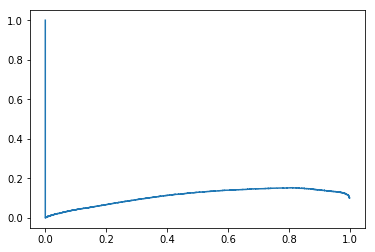

In [255]:
# precision-recall curve
y_scores = -probas
# PR
precision_df, recall_df, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)
# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
auroc_df = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_df, precision_df)
metrics.auc(recall_df, precision_df)

## Plot Results

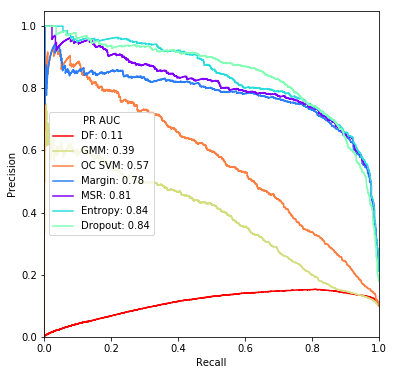

In [256]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]
recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, 
              precision_dropout, precision_gmm, precision_svm, precision_df]
names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'OC SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_pr)))[:, :3]

# plot
plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("../Figures/MNIST/PR_ED_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

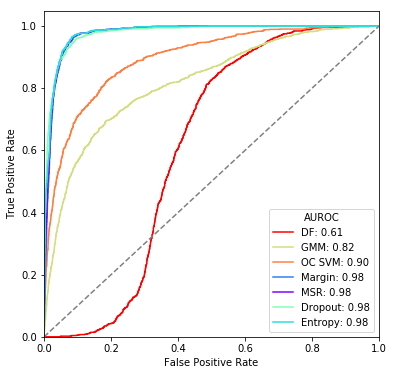

In [257]:
# ROC
# order according to increasing score
scores_auc = [auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_auc)))[:, :3]

# plot
plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(fprs[i], tprs[i], where='post', c=colors_lines[i])

plt.plot([0, 1], [0, 1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("../Figures/MNIST/ROC_ED_wo_cl_" + str(label_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()